<a href="https://colab.research.google.com/github/elogan24/Logan_CaseStudy/blob/main/Logan_Indigo_CaseStudy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Indigo Ag. Case Study - Buyers and Crop Production

Analysis and ranking of potential buyers based on crop production in the continental US

Emily Logan


In [1]:
% pip install geopandas
!pip uninstall rtree
!sudo apt install libspatialindex-dev
!pip install rtree
%pip install jenkspy

     |████████████████████████████████| 994 kB 16.9 MB/s 
     |████████████████████████████████| 6.6 MB 32.1 MB/s 
     |████████████████████████████████| 15.4 MB 35 kB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
0 upgraded, 3 newly installed, 0 to remove and 40 not upgraded.
Need to get 555 kB of archives.
After this operation, 3,308 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-dev amd64 1.8.5-5 [285 kB]
Fetched 555 kB in 0s (5,205 kB/s)
debconf: unable

In [28]:
# Install necessary modules
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rtree
from geopandas.tools import sjoin
import jenkspy
import numpy as np

In [29]:
# Import csv into pandas, convert to geopandas
random_buyers = pd.read_csv("drive/MyDrive/CaseStudy_Indigo/indigo_case_study_500_random_buyers.csv")
rb_locations = gpd.GeoDataFrame(random_buyers, geometry=gpd.points_from_xy(random_buyers.longitude, random_buyers.latitude))

# Import US counties shapefile into geopandas dataframe
us_counties = gpd.read_file("drive/MyDrive/CaseStudy_Indigo/tl_2020_us_county/tl_2020_us_county.shp")

# Import excel with FIPS and corresponding state columns (USDA)
fips_id = pd.read_excel("drive/MyDrive/CaseStudy_Indigo/state_fips.xlsx")

# Import corn acres harvested and yield data from USDA 
corn_acres = pd.read_csv("drive/MyDrive/CaseStudy_Indigo/Corn_Acres.csv")
corn_yield = pd.read_csv("drive/MyDrive/CaseStudy_Indigo/Corn_Yield.csv")

# Import soy acres harvested and yield data from USDA
soy_acres = pd.read_csv("drive/MyDrive/CaseStudy_Indigo/Soy_Acres.csv")
soy_yield = pd.read_csv("drive/MyDrive/CaseStudy_Indigo/Soy_Yield.csv")

# Make coordinate system match for both
rb_locations.crs = us_counties.crs

# Clean US Counties columns
us_counties = us_counties.rename(columns={'NAME':'County'})
us_counties["STATEFP"] = us_counties["STATEFP"].astype(int)

# Only keep continental US based on FIPS (USDA)
indexNames = us_counties[(us_counties['STATEFP'] > 57) | (us_counties["STATEFP"] == 15) | (us_counties["STATEFP"] == 2)].index
us_counties.drop(indexNames, inplace=True)


# Function to clean county names
def clean_county_names(df):
  df['County'] = df['County'].str.upper()
  df['County'] = df['County'].str.strip()
  df['County'] = df['County'].str.replace('\\.', '')
  df['County'] = df['County'].str.replace("\\'", '')
  df['County'] = df['County'].str.replace('\\bSAINT\\b', 'ST')
  df['County'] = df['County'].str.replace('\\bDE KALB\\b', 'DEKALB')
  df['County'] = df['County'].str.replace('\\bLA SALLE\\b', 'LASALLE')
  df['County'] = df['County'].str.replace('\\bLA PORTE\\b', 'LAPORTE')
  df['County'] = df['County'].str.replace('\\bDE SOTO\\b', 'DESOTO')
  df['County'] = df['County'].str.replace('\\bLA MOURE\\b', 'LAMOURE')
  df['County'] = df['County'].str.replace('\\b CITY\\b', '')
  df['County'] = df['County'].str.replace('\\bO BRIEN\\b', 'OBRIEN')

  return df

# Clean county names for US Counties shp, keep only necessary columns
clean_county_names(us_counties)
us_counties = us_counties[["County", "NAMELSAD", "geometry", "STATEFP"]]

# Clean fips_id dataframe
fips_id.columns = fips_id.iloc[4]
fips_id = fips_id[5:]
fips_id.reset_index()

fips_id['Name'] = fips_id['Name'].str.upper()
fips_id = fips_id.rename(columns={'State (FIPS)':'STATEFP'})
fips_id = fips_id.rename(columns={'Name':'State'})

fips_id = fips_id[["STATEFP", "State"]]
fips_id["STATEFP"] = fips_id["STATEFP"].astype(int)
fips_id.drop_duplicates(subset ="STATEFP", keep = False, inplace = True)
fips_id.head()

# Function to clean crop data
def clean_crops(df):
  clean_county_names(df) # Call clean_county_names function at start 

  if(df['Value'].dtype == np.float64 or df['Value'].dtype == np.int64):
    pass
  else:
    df['Value'] = df['Value'].str.replace('\\,', '')

  df['Value'] = df['Value'].astype(float, errors = 'raise')

  # Remove outliers
  Q1 = df['Value'].quantile(0.25)
  Q3 = df['Value'].quantile(0.75)
  IQR = Q3 - Q1 

  filter = (df['Value'] >= Q1 - 1.5 * IQR) & (df['Value'] <= Q3 + 1.5 *IQR)
  df = df.loc[filter]

  new_column = df["Data Item"].loc[1].lower()
  print(new_column)
  df = df.rename(columns = {'Value': new_column+'_value'})
  df = df.rename(columns = {'CV (%)': new_column+'_cv'})
  df = df[["State", "County", new_column+'_value', new_column+'_cv', "Commodity"]].copy()
  df.columns = df.columns.str.replace(' ','')
  df.columns = df.columns.str.replace('-','_')
  df.columns = df.columns.str.replace(',','')
  df.columns = df.columns.str.replace('measuredinbu/acre','')
  df = df.merge(fips_id, on = ["State"])
  df.drop(columns = ["State"], axis = 1, inplace = True)

  return df

# Call function, clean crop data
corn_yield_clean = clean_crops(corn_yield)
corn_acres_clean = clean_crops(corn_acres)
soy_acres_clean = clean_crops(soy_acres)
soy_yield_clean = clean_crops(soy_yield)


#Check for areas with CV % greater than 100. Remove those areas. 
soy_yield_clean[soy_yield_clean.soybeans_yield_cv > 100].count()
soy_acres_clean[soy_acres_clean.soybeans_acresharvested_cv > 100].count()

corn_yield_clean[corn_yield_clean.corngrain_yield_cv > 100].count()
corn_acres_clean[corn_acres_clean.corngrain_acresharvested_cv > 100].count()

soy_yield_clean = soy_yield_clean[soy_yield_clean['soybeans_yield_cv']<100]
soy_acres_clean = soy_acres_clean[soy_acres_clean['soybeans_acresharvested_cv']<100]
corn_yield_clean = corn_yield_clean[corn_yield_clean['corngrain_yield_cv']<100]
corn_acres_clean = corn_acres_clean[corn_acres_clean['corngrain_acresharvested_cv']<100]

corn_acres_clean.head()

# merge yields and acres harvested together
corn = us_counties.merge(corn_yield_clean, on=["STATEFP", "County"], how = "outer")
corn = corn.merge(corn_acres_clean, on = ["STATEFP", "County"], how = "outer")

soy = us_counties.merge(soy_yield_clean, on=["STATEFP", "County"], how = "outer")
soy = soy.merge(soy_acres_clean, on = ["STATEFP", "County"], how = "outer")


# Calculate corn and soy production in bushels from yield and acreage
corn["production"] = corn["corngrain_yield_value"]*corn["corngrain_acresharvested_value"]
soy["production"] = soy["soybeans_yield_value"]*soy["soybeans_acresharvested_value"]
soy.head()

# Only keep necessary columns
soy_pd = soy[["County", "STATEFP", "production", "Commodity_y"]]
corn_gpd = corn[["County", "STATEFP", "NAMELSAD", "geometry", "production", "Commodity_y"]]

# Merge corn and soy to get dataframe of total production
total = corn_gpd.merge(soy_pd, on = ["STATEFP", "County"], how = "outer")
total["Commodity_y"] = "combined"
total.shape

# Calculate total production, only keep necessary columns
total['production_x'] = total['production_x'].fillna(0)
total['production_y'] = total['production_y'].fillna(0)
total["production"] = total["production_x"] + total["production_y"]

total = total[["County", "NAMELSAD", "geometry", "STATEFP", "production", "Commodity_y"]]
soy = soy[["County", "NAMELSAD", "geometry", "STATEFP", "Commodity_y", "production"]]
corn = corn[["County", "NAMELSAD", "geometry", "STATEFP", "Commodity_y", "production"]]

# Combine soy, corn and total into one dataframe, remove null values
all_production = soy.append(corn)
all_combined_prod = all_production.append(total)
all_production = all_production.dropna(subset=['Commodity_y'])
all_production.head()




corn, grain - yield, measured in bu / acre
corn, grain - acres harvested
soybeans - acres harvested
soybeans - yield, measured in bu / acre


,County,NAMELSAD,geometry,STATEFP,Commodity_y,production
0,CUMING,Cuming County,"POLYGON ((-97.01952 42.00410, -97.01952 42.004...",31,SOYBEANS,6085840.0
3,LANCASTER,Lancaster County,"POLYGON ((-96.91075 40.78494, -96.91075 40.790...",31,SOYBEANS,6495280.0
4,NUCKOLLS,Nuckolls County,"POLYGON ((-98.27367 40.08940, -98.27367 40.089...",31,SOYBEANS,4656250.0
5,MINNEHAHA,Minnehaha County,"POLYGON ((-96.89022 43.84836, -96.88980 43.848...",46,SOYBEANS,7311420.0
8,CLINTON,Clinton County,"POLYGON ((-85.23910 36.76983, -85.23443 36.786...",21,SOYBEANS,120012.0


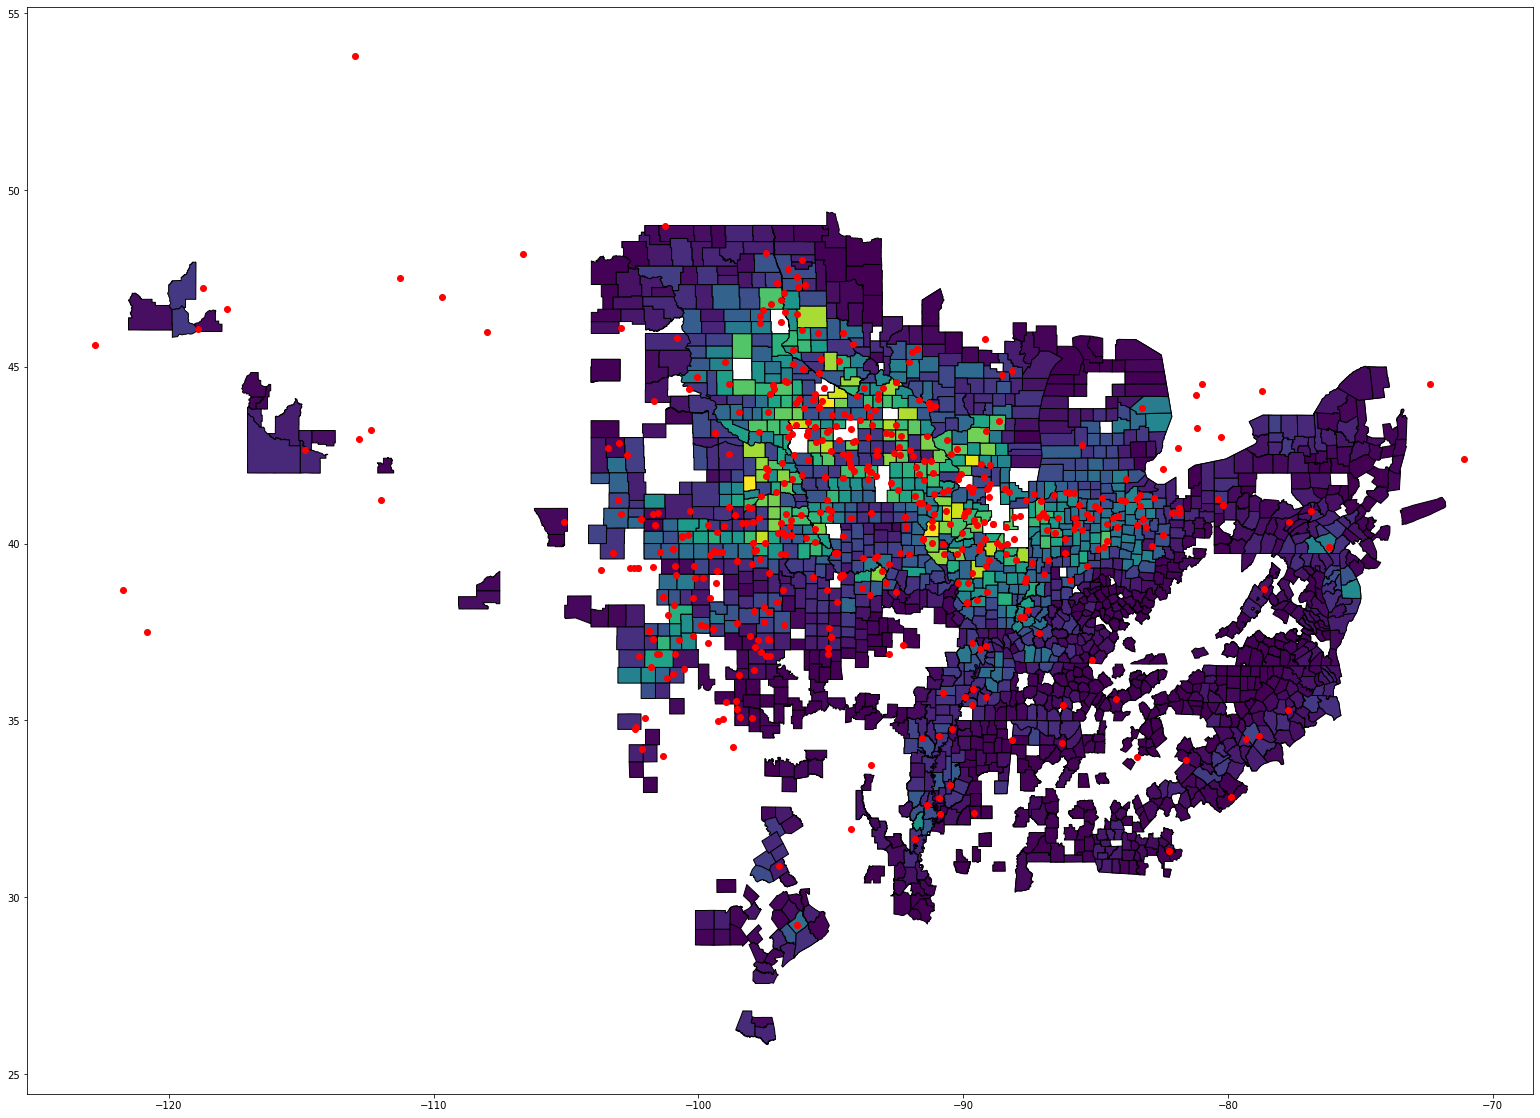

In [25]:
# Preliminary test view of all production and buyers

base = all_production.plot(edgecolor = "black", column = "production", figsize = (50,20))
rb_locations.plot(ax = base, marker = 'o', color = 'red')

Now that the data is cleaned, we can move on to the analysis

   id   latitude   longitude                     geometry
0   1  37.981011 -101.131373  POINT (-101.13137 37.98101)
1   2  38.749860  -93.840057   POINT (-93.84006 38.74986)
2   3  42.863391  -95.542792   POINT (-95.54279 42.86339)
3   4  32.370266  -89.612160   POINT (-89.61216 32.37027)
4   5  39.749561  -86.168043   POINT (-86.16804 39.74956)


/usr/local/lib/python3.7/dist-packages/jenkspy/core.py:103: UserWarning: Invalid values encountered (NaN or Inf) were ignored
  warnings.warn('Invalid values encountered (NaN or Inf) were ignored')
/usr/local/lib/python3.7/dist-packages/jenkspy/core.py:103: UserWarning: Invalid values encountered (NaN or Inf) were ignored
  warnings.warn('Invalid values encountered (NaN or Inf) were ignored')


[0, 41720.0, 8641865.0, 16988740.0, 24056680.0, 34149150.0]
[0, 14501.5, 2434395.0, 4743473.333333333, 6855206.666666667, 10404560.0]


/usr/local/lib/python3.7/dist-packages/jenkspy/core.py:103: UserWarning: Invalid values encountered (NaN or Inf) were ignored
  warnings.warn('Invalid values encountered (NaN or Inf) were ignored')


[0, 4466.0, 7222886.666666667, 14353920.0, 22203460.0, 43913880.0]


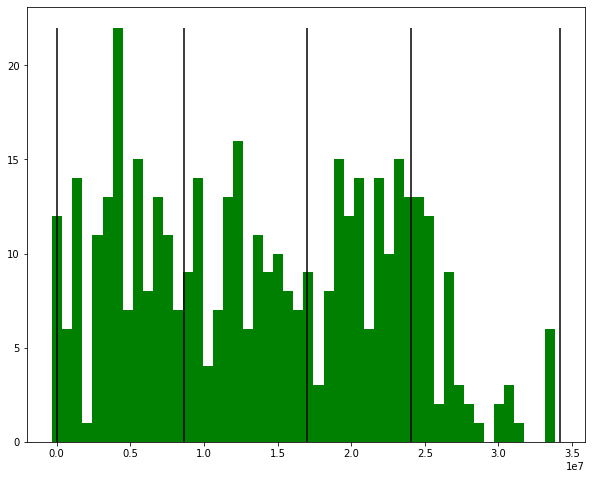

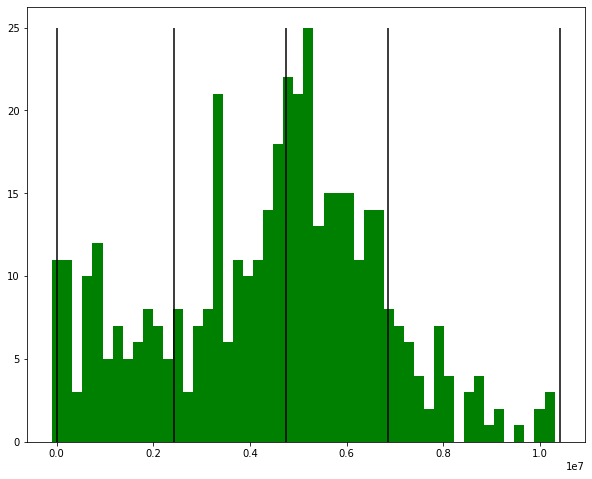

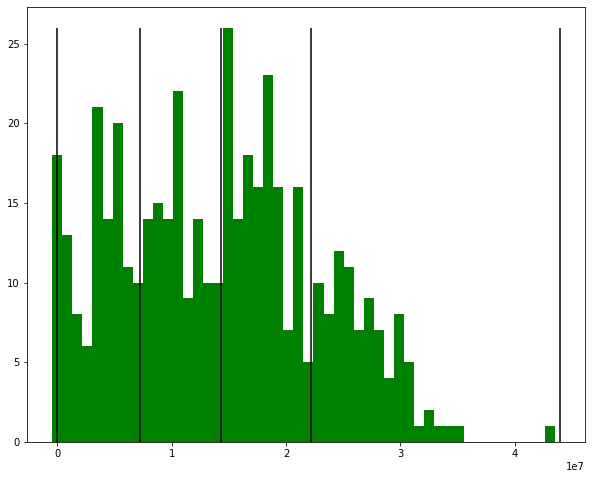

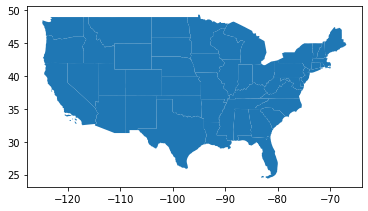

In [30]:
# Clip random buyers to the continental us counties
rb_us = gpd.clip(rb_locations, us_counties)
print(rb_us.head())

# Create 10 mile buffer around random buyers
rb_locations["geometry"] = rb_locations.to_crs(epsg=5070).buffer(16093).to_crs(epsg=4326)

# Overlay, via intersection, with all production dataframe and only keep necessary columns
merged = gpd.overlay(all_combined_prod, rb_locations, how='intersection')
merged = merged[["production", "Commodity_y", "id", "geometry"]]
merged.head()

# Groupby id and commodity and calculate mean of corn production
buyer_temp = merged.groupby(['id', "Commodity_y"])[['production']].mean()
buyer_temp.reset_index(inplace = True)
buyer_temp.head()

# Merge random buyers grouped by id and commodity with location data 
buyers = rb_us.merge(buyer_temp, on = ["id"], how = "outer")
buyers.shape
buyers.head()

# Disaggregate commodities and merge with all buyers, clipped to usa
def agg_comm(comm_name):
  comm_buyers_temp = buyer_temp.loc[buyer_temp['Commodity_y'] == comm_name]
  buyers = rb_us.merge(comm_buyers_temp, on = ["id"], how = "outer")
  buyers['Commodity_y'] = buyers['Commodity_y'].fillna(comm_name)
  buyers['production'] = buyers['production'].fillna(0)
  
  return buyers

buyers_corn = agg_comm("CORN")
buyers_soy = agg_comm("SOYBEANS")
buyers_total = agg_comm("combined")

# Create histogram based on natural jenks for corn, soy and total
def hist_analysis(df):
  df = df[df.production != 0]
  hist_analysis = df[["production"]].to_numpy()
  hist_analysis = np.ma.masked_equal(hist_analysis,0)
  array_sum = np.sum(hist_analysis)
  array_has_nan = np.isnan(array_sum)

  breaks = jenkspy.jenks_breaks(hist_analysis, nb_class=4)

  plt.figure(figsize = (10,8))
  hist = plt.hist(hist_analysis, bins=50, align='left', color='g')
  for b in breaks:
    plt.vlines(b, ymin=0, ymax = max(hist[0]))

  bins=[0]

  for b in breaks:
    bins.append(b)

  return bins

bins = hist_analysis(buyers_corn)
print(bins)
buyers_corn.shape

buyers_corn['Jenks_class'] = pd.cut(buyers_corn['production'],bins,labels=[0,1,2,3,4], include_lowest=True)
buyers_corn["Jenks_class"] = buyers_corn["Jenks_class"].astype(int)

bins = hist_analysis(buyers_soy)
print(bins)
buyers_soy.head()

buyers_soy['Jenks_class'] = pd.cut(buyers_soy['production'],bins,labels=[0,1,2,3,4], include_lowest=True)
buyers_soy["Jenks_class"] = buyers_soy["Jenks_class"].astype(int)

bins = hist_analysis(buyers_total)
print(bins)
buyers_total.shape

buyers_total['Jenks_class'] = pd.cut(buyers_total['production'],bins,labels=[0,1,2,3,4], include_lowest=True)

# Create final buyers dataframe from soy, corn and combined
final_buyers = buyers_soy.append(buyers_corn)
final_buyers = final_buyers.append(buyers_total)

# Dissolve counties dataframe by STATEFP to create states for boundary
states = us_counties.dissolve(by='STATEFP')
states = states.merge(fips_id, on="STATEFP")
states = states[["geometry", "State"]]
states.plot()

In [31]:
# Export to shapefiles
final_buyers.to_file("drive/MyDrive/CaseStudy_Indigo/final_buyers.shp")
all_production.to_file("drive/MyDrive/CaseStudy_Indigo/all_production.shp")
states.to_file("drive/MyDrive/CaseStudy_Indigo/states.shp")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  This is separate from the ipykernel package so we can avoid doing imports until
